### Testing the Properties of In-Context Learning

For training we use the same specific token construction as in von Oswald et al., 2022 i.e. concatinate input and targets i.e. $e_i = (x_i,y_i)$. For the last index $i$ we set $y_i$ to $0$ and the transformer is trained to predict its value.

In [1]:
import pickle
import matplotlib.pyplot as plt

import jax
import optax
import jax.numpy as jnp

from meta_icl.transformer import Transformer
from meta_icl.data import sample_regression_dataset

In [3]:
# Configuration
main_rng = jax.random.key(42)
lr = 3e-4
num_epochs = 3_000
batch_size = 15_000

set_size = 10
key_size = 11
input_size = 10
num_layers = 1
num_heads = 1

# Model definition
model = Transformer(
    num_heads=num_heads,
    key_size=key_size,
    num_layers=num_layers,
    output_size=1,
    ic_length=set_size + 1,
    use_pe=False,
    use_bias=False,
    only_attention=True, # No MLP after the MHA block if True
    use_layer_norm=False,
    use_non_lin_mix=False,
    sum_norm=False,
    use_softmax=False  # Linear self-attention if set to False
)

# Initialization
rng_init, rng_apply = jax.random.split(main_rng)
x = jnp.ones((1, 11, key_size))  # Input tensor
params = model.init(rng_init, x, is_training=True)  # Initialize parameters
y = model.apply(params, x, is_training=True)  # Example forward pass

# Optionally load pretrained weights from
# with open("output/transformer_1l_1h.pkl", "rb") as f:
#     params = pickle.load(f)

# Optimizer
opt_adam = optax.adam(learning_rate=lr)
opt_params = opt_adam.init(params)

Training of the transformer by sampling a new batch of simple regression tasks at each epoch, basically training the transformer like you would for a meta-learning model on a distribution of tasks.

In [224]:
@jax.jit
def train_step(params, opt_params, X, y):
    def compute_mse_loss(params, X, y):
      # Obtain the final prediction
      y_hat, _, _ = model.apply(params, X, is_training=True)
      y_hat = y_hat[:, -1, -1]

      loss = jnp.mean((y_hat - y[:, -1]) ** 2)  # MSE loss
      return loss

    loss_grad_fn = jax.value_and_grad(compute_mse_loss)
    loss, grads = loss_grad_fn(params, X, y)

    updates, opt_params = opt_adam.update(grads, opt_params, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_params


losses = []
for epoch in range(num_epochs):
    X, y, _ = sample_regression_dataset(main_rng, input_size, batch_size=batch_size, set_size=set_size, input_range=1.0)

    loss, params, opt_params = train_step(params, opt_params, X, y)
    losses.append(float(loss))

    if epoch % 500 == 0:
        print(f"epoch {epoch}/{num_epochs}: loss: {loss}")

with open(f"transformer_{num_layers}l_{num_heads}h.pkl", "wb") as f:
     pickle.dump(params, f)

epoch 0/3000: loss: 0.9956815838813782
epoch 500/3000: loss: 0.8028658032417297
epoch 1000/3000: loss: 0.7661433815956116
epoch 1500/3000: loss: 0.44666779041290283
epoch 2000/3000: loss: 0.42086803913116455
epoch 2500/3000: loss: 0.420803964138031


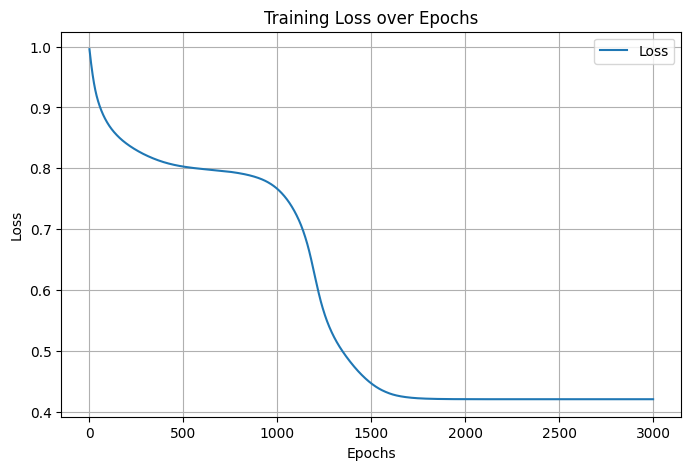

In [225]:
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

In [4]:
# Create a new set of evaluation data to inspect the layers
X_eval, y_eval, _ = sample_regression_dataset(jax.random.key(43), input_size=input_size, batch_size=100, input_range=1.0)
X_eval.shape

(100, 11, 11)

### Analysis of the Weights

The framework of Goh et al., 2021 explores the structure in transformer models. Here they see particular behavior in the attention head which might be connected to a concept which they call _induction heads_, these heads seem to contribute significantly to the in-context learning ability of transformers. These induction heads should exhibit approximately two properties:

- **Prefix matching**: The head attends back to previous tokens that were followed by the current and/or recent token. It attends to the token which induction would suggest comes next.
- **Copying**: The head's output increases the logit corresponding to the attended to token.

For the copying behavior, I inspect one of the two circuits they talk about most. The first circuit is the query-key ($W_q \cdot W_k$) which provides the attention score for eveyr query and key token (describes how much a given query token "wants" to attend to a given key token). The second the output-value ($W_o \cdot W_v$) circuit which describes how a given token will affect the output logits if attended to.

Finally, how you would find one of these copying matrices? They argue that one possibility is to look at the diagonal of a matrix, which describes how each token affects its own probability. And mention that "It's worth noting that all of these potential notions of copying are linked by the fact that the sum of the eigenvalues is equal to the trace is equal to the sum of the diagonal."

#### Visualization of the attention head outputs

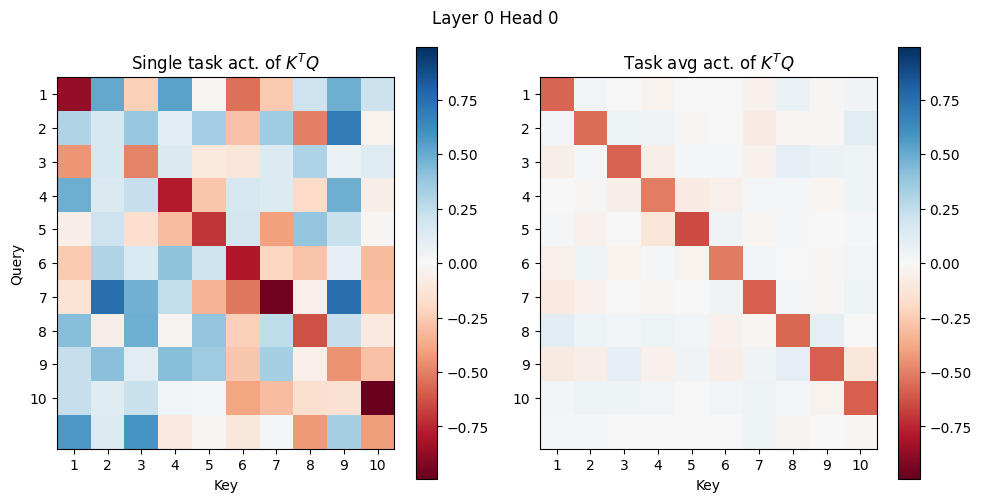

In [228]:
# Generate a number of evaluation tasks
y_hat, attn, hidden = model.apply(params, X_eval, is_training=True)

for n in range(num_layers):
  for head in range(attn[n].shape[1]):
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
    fig.suptitle(f"Layer {n} Head {head}")

    ax1.set_yticks(ticks=range(0, key_size-1))
    ax1.set_yticklabels(range(1, key_size))
    ax1.set_xticks(ticks=range(0, key_size+1))
    ax1.set_xticklabels(range(1, key_size+2))

    ax2.set_yticks(ticks=range(0, key_size-1))
    ax2.set_yticklabels(range(1, key_size))
    ax2.set_xticks(ticks=range(0, key_size+1))
    ax2.set_xticklabels(range(1, key_size+2))

    ax1.set_xlabel("Key")
    ax1.set_ylabel("Query")
    ax2.set_xlabel("Key")
    ax1.set_title("Single task act. of $K^TQ$")
    ax2.set_title("Task avg act. of $K^TQ$")

    single = jnp.squeeze(attn[n][0, head, :, :])
    mean = jnp.mean(attn[n][:, head, :, :], axis=0)
    vmin = jnp.max(jnp.array([jnp.abs(single), jnp.abs(mean)]))

    pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pos = ax2.imshow(mean, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax2, shrink=1)

    fig.tight_layout()
    plt.show()

#### Visualization of matrices $W_K^T W_V$ and $W_O W_V$

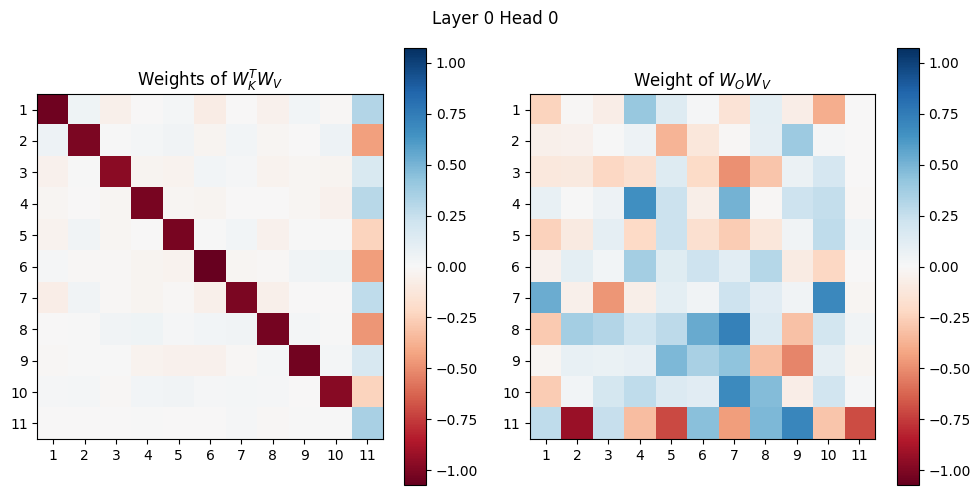

In [229]:
for n in range(num_layers):
  for head in range(num_heads):
    KQ = jnp.identity(set_size + 1)
    LV = jnp.identity(set_size + 1)

    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
    fig.suptitle(f"Layer {n} Head {head}")
    ax1.set_yticks(ticks=range(0, key_size))
    ax1.set_yticklabels(range(1, key_size+1))
    ax1.set_xticks(ticks=range(0, key_size))
    ax1.set_xticklabels(range(1, key_size+1))

    ax2.set_yticks(ticks=range(0, key_size))
    ax2.set_yticklabels(range(1, key_size+1))
    ax2.set_xticks(ticks=range(0, key_size))
    ax2.set_xticklabels(range(1, key_size+1))

    for k, v in params["params"]["attn_block"].items():
      if "key" in k:
        KQ = jnp.matmul(KQ, v['kernel'][:, head*key_size: (head+1)*key_size])
      elif "query" in k:
        KQ = jnp.matmul(KQ, v['kernel'][:, head*key_size: (head+1)*key_size].T)
      elif "value" in k:
        LV = jnp.matmul(v['kernel'][:, head*key_size: (head+1)*key_size], LV)
      elif "final_proj" in k:
        LV = jnp.matmul(v['kernel'][head*key_size: (head+1)*key_size, :], LV)

    vmin = jnp.max(jnp.array([jnp.abs(KQ), jnp.abs(LV)]))

    ax1.set_title("Weights of $W^T_KW_V$")
    pos = ax1.imshow(KQ, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax1, shrink=1)

    ax2.set_title("Weight of $W_OW_V$")
    pos = ax2.imshow(LV, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax2, shrink=1)

    fig.tight_layout()
    plt.show()

So, can we see similar behavior in the eigenvalues of these matrices? Where mostly positive eigenvalues mean there might be a lot of copying going on in the head.

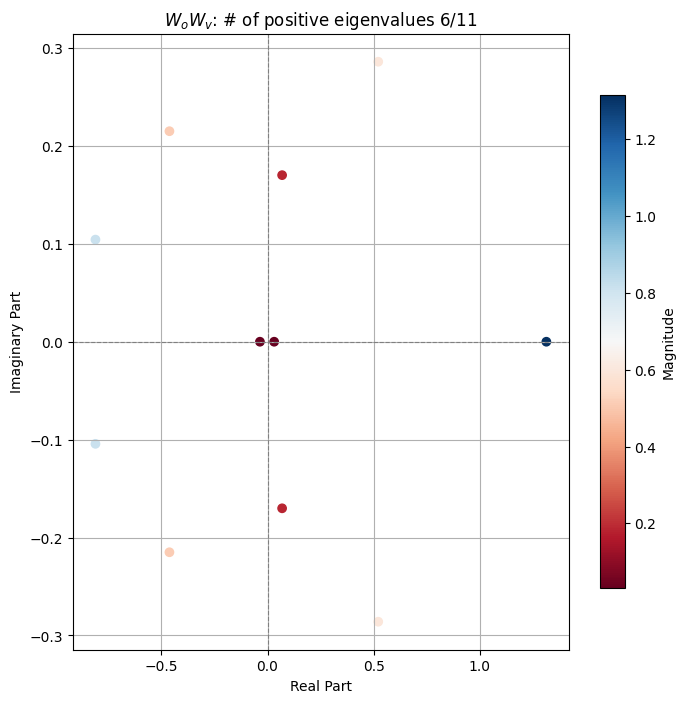

In [7]:
W_o = params["params"]["attn_block"]["final_proj"]["kernel"]
W_v = params["params"]["attn_block"]["value"]["kernel"]
W_oW_v = W_o @ W_v

eigenvalues = jnp.linalg.eigvals(W_oW_v)
magnitudes = jnp.abs(eigenvalues)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    eigenvalues.real, eigenvalues.imag,
    c=magnitudes, cmap='RdBu', marker='o'
)
plt.colorbar(scatter, label='Magnitude', shrink=0.8)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
plt.title("$W_{o}W_{v}$" + f": # of positive eigenvalues {sum(eigenvalues > 0)}/{len(eigenvalues)}")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

### Example of the task

Just to show this is a simple regression task with the input $X^{10}$ and target $y$. This is not the most optimized model for the task but more to show what the target is for the model, it is only trained to guess the correct $y$ value at the end of the regression sequence.

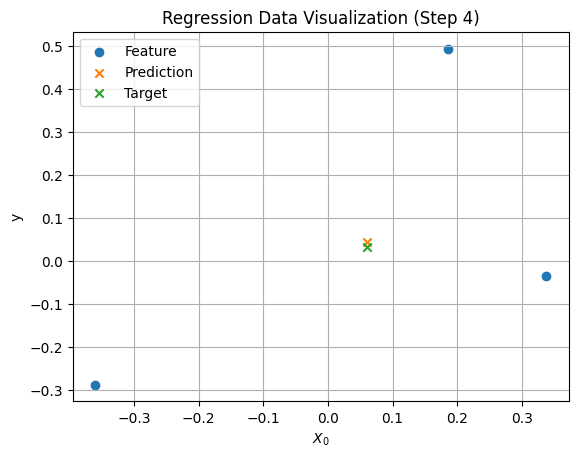

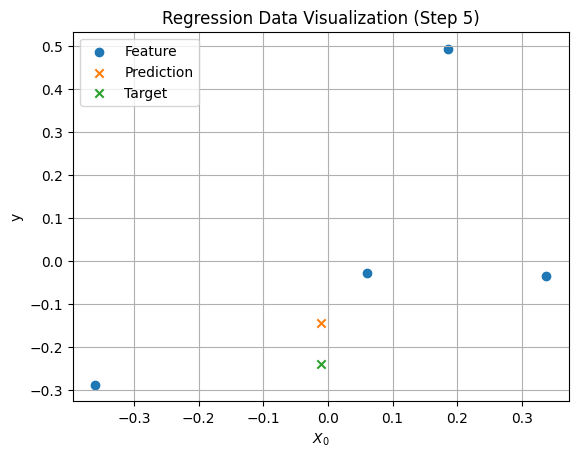

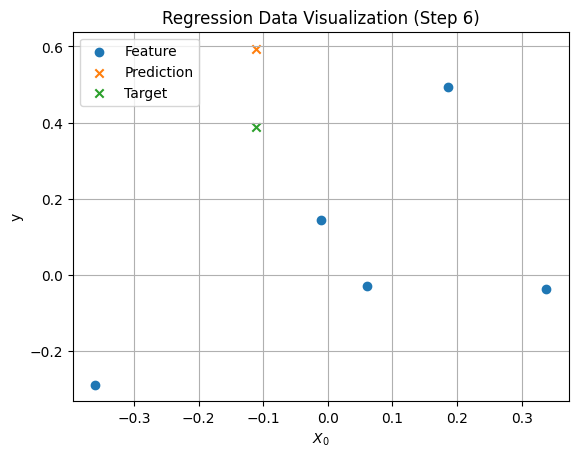

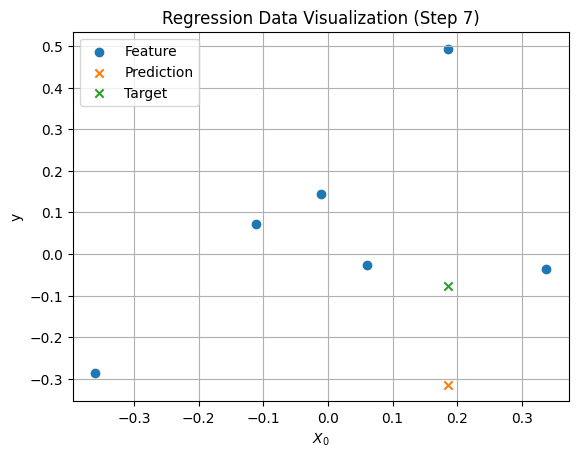

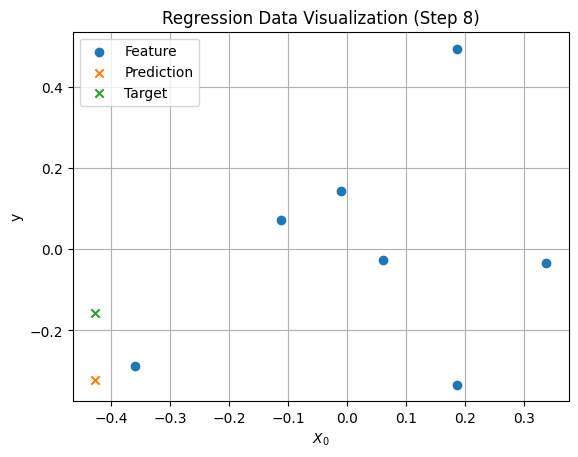

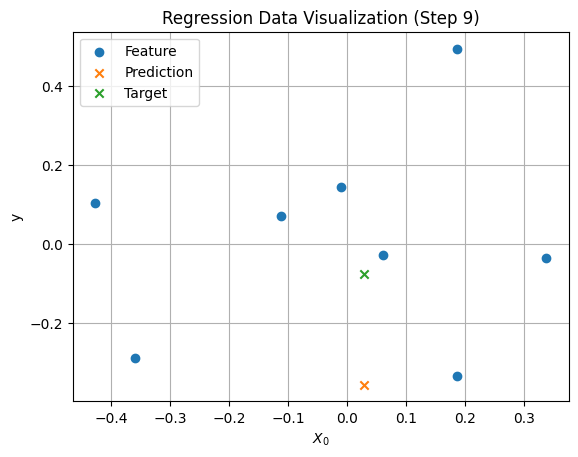

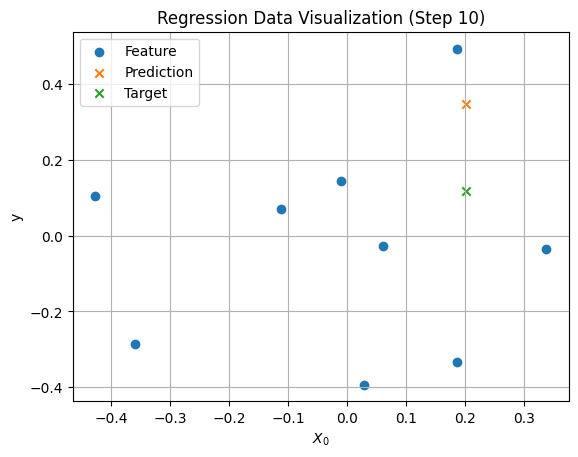

In [15]:
indice = 57
for step in range(4, X_eval.shape[1]):
    plt.clf()
    
    masked_X = X_eval[indice, :step, :].copy()  
    plt.scatter(masked_X[:, 0][:step-1], masked_X[:, 1][:step-1], label='Feature', marker='o')

    # Mask out the last index corresponding to the y value
    masked_X = jnp.expand_dims(masked_X.at[-1, 1].set(0.0), 0)
    y_hat, *_ = model.apply(params, masked_X, is_training=True)
    y_hat = y_hat[:, -1, -1]
    
    plt.scatter([masked_X[0, -1, 0]], y_hat, label='Prediction', marker='x')
    plt.scatter([masked_X[0, -1, 0]], y_eval[indice, step], label='Target', marker='x')
    
    # Highlight the unmasked part
    plt.title(f'Regression Data Visualization (Step {step})')
    plt.xlabel('$X_0$')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()